# Simple 2D Convolutional Neural Network for ECG Binary **Classification**

The following notebook indroduce a short light CNN model for EGC Binary Classification.

## Dataset and dependecies loading

In [1]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -q -r chagas/requirements.txt


# Download the dataset
import gdown
url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Cloning into 'chagas'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 645 (delta 100), reused 113 (delta 40), pack-reused 438 (from 1)
Receiving objects: 100% (645/645), 9.59 MiB | 23.67 MiB/s, done.
Resolving deltas: 100% (314/314), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 20.5 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=079ab0c1-bc74-41fb-a9eb-079ed3c8753d
To: /content/dataset.zip
100%|██████████| 623M/623M [00:05<00:00, 111MB/s]


In [2]:
import sys
sys.path.append("/content/chagas/src")


import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

This code sets up the validation and test datasets for a Chagas disease classification task using ECG recordings. It begins by defining a custom noise reduction filter (`FiltfiltNoiseReducer`) with parameters tailored for ECG signals sampled at 400 Hz. Then, using a data loader (`WfdbLoader`), it applies the filter and loads ECG recordings labeled for the presence or absence of Chagas disease from specified directories. The data is shuffled during loading to ensure randomized batches. Finally, the metadata for the test set is retrieved for further analysis or tracking.


In [3]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer


data_path = "/content/chagas/data/big_splitted_dataset/"

# Noise reduction filter
filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

# training set loading and preprocessing
train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading and preprocessing
validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading and preprocessing
test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:15<00:00, 145.38record/s]


## Training

This model serves as a lightweight and modular starting point for classifying ECG signals. It takes as input a 12-lead ECG time series of shape (2800, 12), corresponding to 7 seconds of data sampled at 400 Hz. The input is first processed through a custom `LightLogSpectrogram` layer, which transforms the time-domain signals into a compact logarithmic spectrogram representation. This spectrogram is then passed through two simple 2D convolutional layers with increasing filter sizes (32 and 64), followed by pooling operations to reduce spatial dimensions. The filter sizes and the number of filters were empirically chosen to strike a balance between model simplicity and performance at this early stage. A global average pooling layer flattens the output before a final dense layer with sigmoid activation produces a binary classification output. This setup is intended as a reference baseline to facilitate experimentation and iterative improvements.


In [4]:
from models.layers import LightLogSpectrogram


def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="small_cnn")

# Compilazione del modello
model = build_cnn_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "small_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ light_log_spectrogram           │ (None, 88, 64, 12)     │             0 │
│ (LightLogSpectrogram)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_32 (Conv2D)                │ (None, 88, 64, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_64 (Conv2D)                │ (None, 44, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,049 (86.13 KB)

 Trainable params: 22,049 (86.13 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Callback: early stopping and saving best model
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.4992 - auc: 0.4979 - loss: 0.7263 - val_accuracy: 0.5134 - val_auc: 0.6824 - val_loss: 0.6844
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5814 - auc: 0.6205 - loss: 0.6720 - val_accuracy: 0.6185 - val_auc: 0.6850 - val_loss: 0.6497
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6264 - auc: 0.6788 - loss: 0.6438 - val_accuracy: 0.6275 - val_auc: 0.7034 - val_loss: 0.6441
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6424 - auc: 0.6950 - loss: 0.6343 - val_accuracy: 0.6488 - val_auc: 0.7058 - val_loss: 0.6322
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6538 - auc: 0.7107 - loss: 0.6246 - val_accuracy: 0.5936 - val_auc: 0.7180 - val_loss: 0.6602
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6489 - auc: 0.7021 - loss: 0.6303 - val_accuracy: 0.6551 - val_auc: 0.7271 - val_loss: 0.6273
Epoch 7/50
262/262 ━━━━━━━━━━━━━━

## Analisi del modello

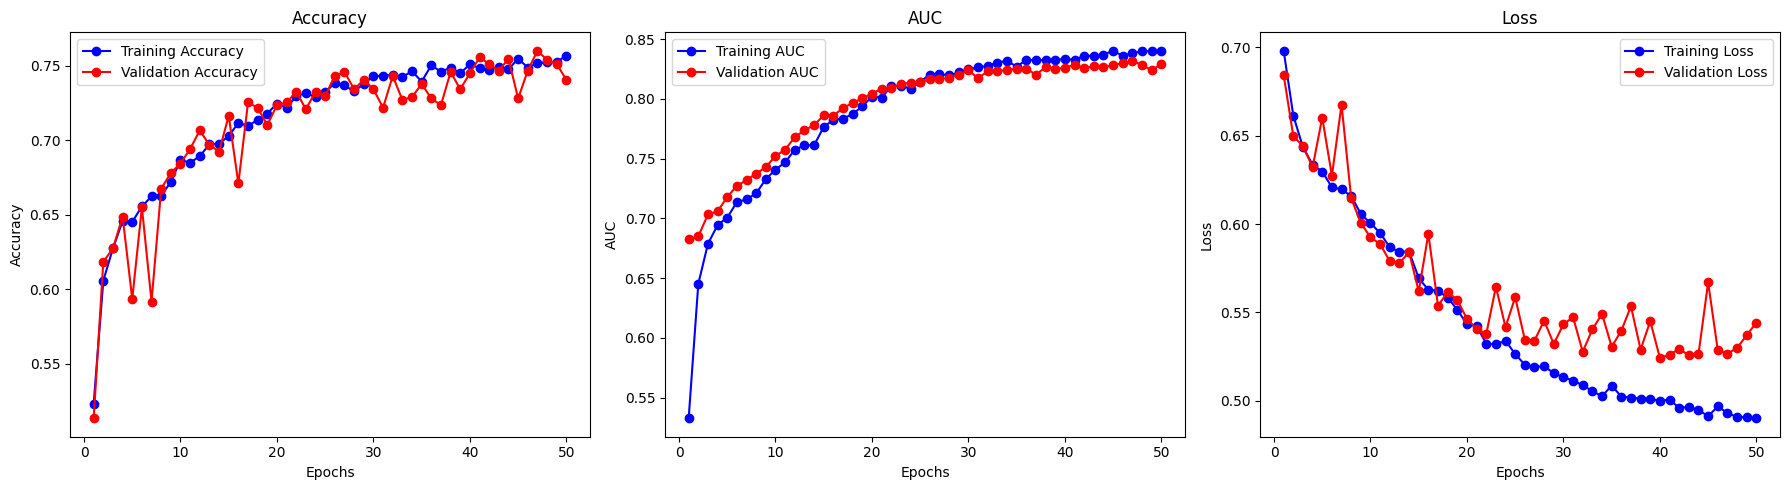

In [6]:
from models.analysis import plot_training_metrics

# accuracy, AUC and loss plot
plot_training_metrics(history)

In [10]:
from models.utils import find_optimal_threshold, compute_predictions
from sklearn.metrics import classification_report, accuracy_score
from models.layers import TemporalMeanPooling


# Load the trained Keras model from file, specifying any custom layers used
model = tf.keras.models.load_model(
    "best_model.keras",
    safe_mode=False,
    custom_objects={'LightLogSpectrogram': LightLogSpectrogram}
)

# Generate predicted probabilities on the validation set
y_pred_probs = model.predict(X_val)

# Find the optimal classification threshold based on the validation set
threshold = find_optimal_threshold(y_val, y_pred_probs)

# Compute final predictions, predicted classes, and correctness flags on the test set
y_pred, y_pred_classes, correct = compute_predictions(model, X_test, y_test, threshold)

# Print a detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred_classes))

# Compute and store the overall accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)
print(accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step
Optimal threshold: 0.493
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1126
           1       0.76      0.77      0.76      1119

    accuracy                           0.76      2245
   macro avg       0.76      0.76      0.76      2245
weighted avg       0.76      0.76      0.76      2245

0.7612472160356347


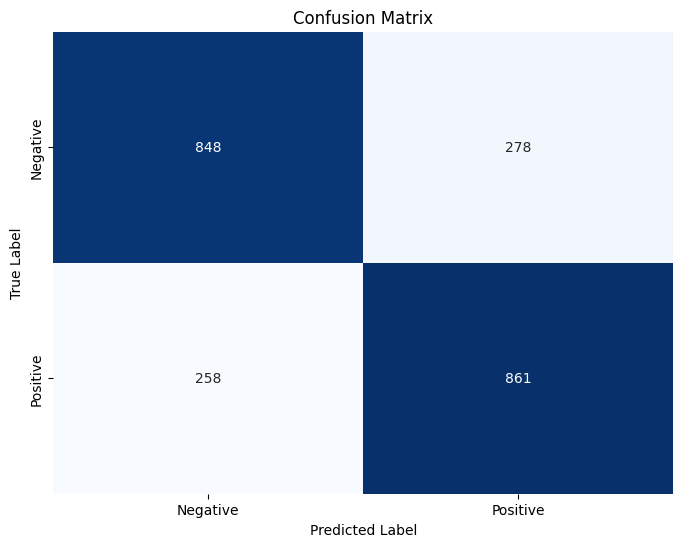

In [8]:
from models.analysis import plot_confusion_matrix


# Confusion matrix
plot_confusion_matrix(y_test, y_pred_classes)

The next cell provides a summary of the distribution of the model's output scores.

- **Distribution of predictions**: Displays the distribution of predicted probabilities, highlighting correct (blue) and incorrect (red) classifications. A vertical dashed line indicates the 0.5 threshold, which may vary depending on the decision criterion.

- **Source distribution by model output**: Shows how the model's output scores (x-axis) are distributed across subgroups defined by data origin and label. This allows us to assess how different dataset segments are classified and to detect potential imbalances. Groups include:

    - Chagas-negative cases from CODE-15% (light teal),

    - Chagas-positive cases from CODE-15% (teal),

    - Chagas-positive cases from SaMi-Trop (yellow).

- **Age distribution for correct predictions**: Depicts the distribution of model outputs for correctly classified samples, stratified by age group. This provides insight into how prediction confidence varies across age.

- **Age distribution for incorrect predictions**: Analogous to the previous chart but focused on misclassifications. It helps identify age groups with higher error rates or ambiguous outputs.

- **Prediction success rate by age**: Summarizes the model's classification accuracy by age group, expressed as a percentage of correct predictions. Sample counts per group are reported above each bar for context.

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


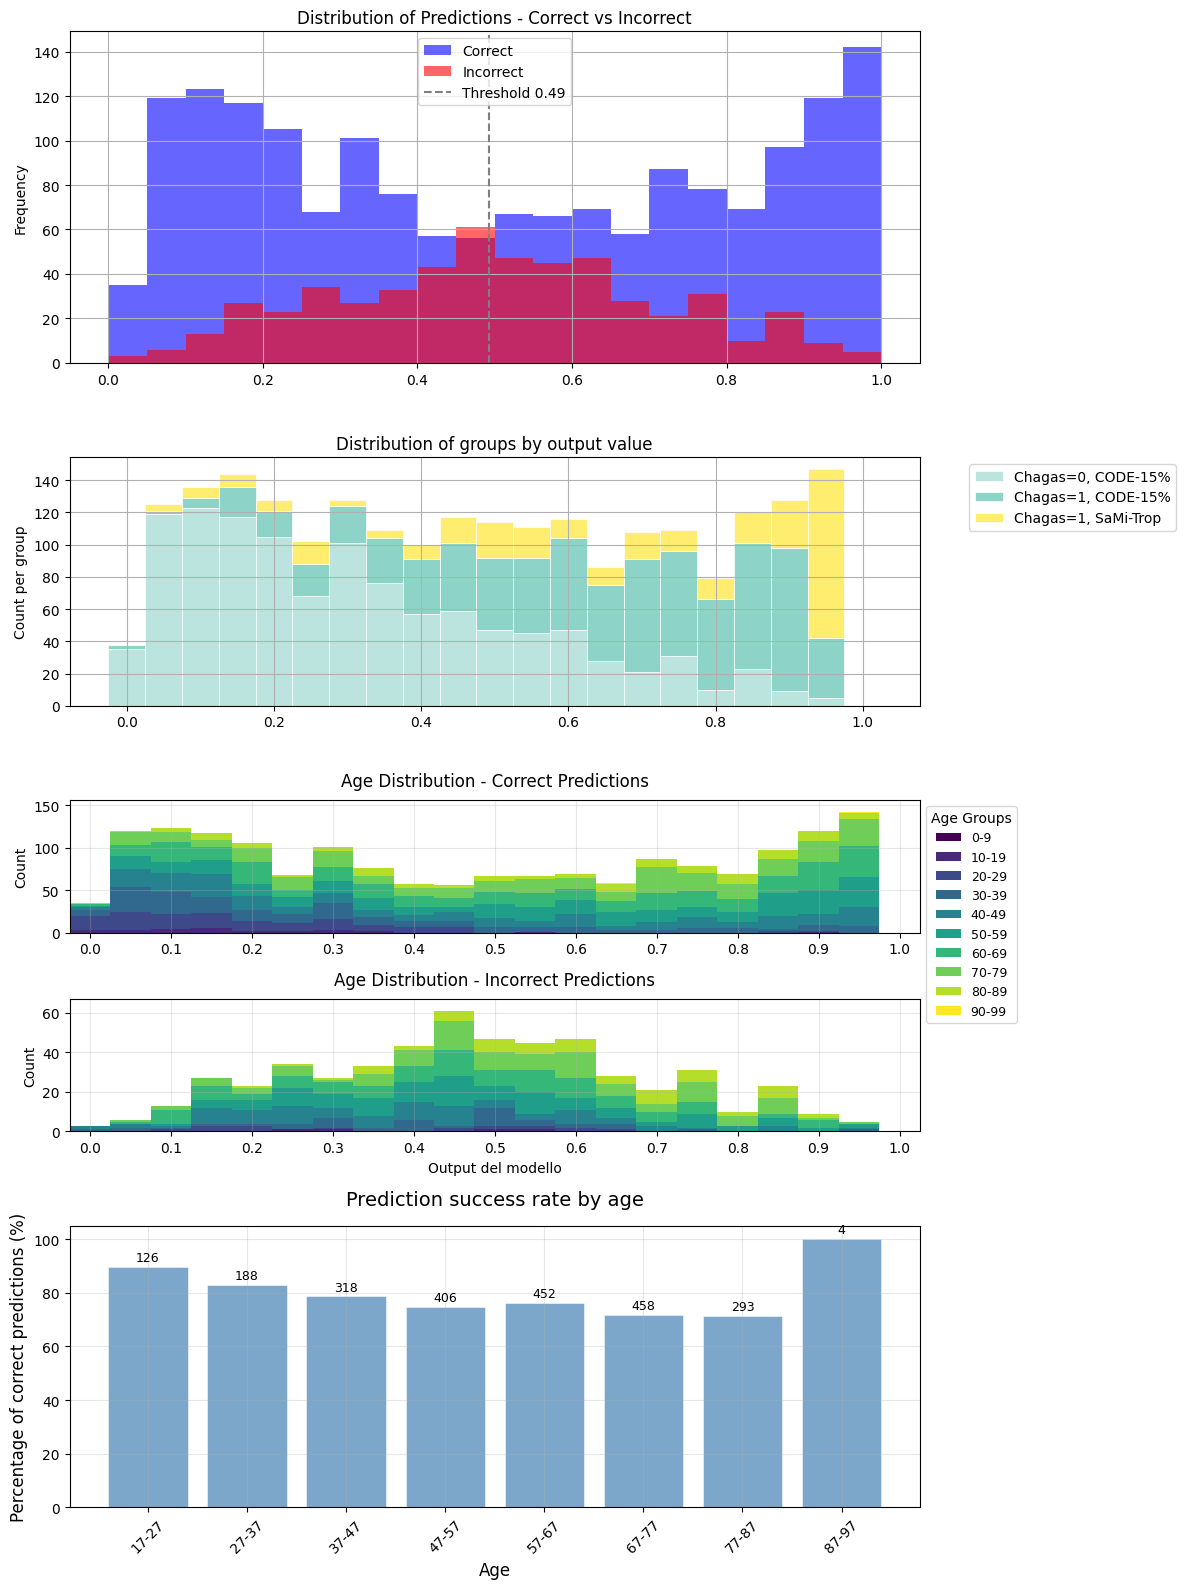

In [9]:
from models.analysis import plot_model_analysis

plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=False)